## Обработка графиков ЭКГ и преобразование в таблицу

In [2]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
#from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

In [55]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [56]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [57]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-3])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 11.4 s
Wall time: 11.9 s


In [58]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'record_name'})

In [59]:
ECG_data = ECG_data.sort_values(by=['record_name'], ascending=True)

In [60]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## Объединение таблиц, разбиение на тренировочную и валидационную выборки

In [61]:
df = pd.read_csv('train/train_meta.csv')
df.record_name = list(map(lambda x: int(x.strip('_hr')), df.record_name))
df

,patient_id,age,sex,height,weight,record_name
0,18792.0,55.0,0,NaN,70.0,9
1,13619.0,56.0,0,NaN,NaN,34
2,11315.0,25.0,1,NaN,63.0,43
3,18153.0,35.0,0,NaN,82.0,52
4,16063.0,26.0,0,NaN,93.0,57
...,...,...,...,...,...,...
2096,12488.0,66.0,1,NaN,NaN,21784
2097,10162.0,68.0,0,NaN,NaN,21795
2098,11197.0,59.0,0,NaN,NaN,21825
2099,11905.0,55.0,1,NaN,NaN,21831


In [62]:
ECG_data = ECG_data.merge(df, on='record_name', how='left')

In [63]:
gts = pd.read_csv('train/train_gts_final.csv')
gts.record_name = list(map(lambda x: int(x.strip('_hr')), gts.record_name))
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма,record_name
0,0,0,0,0,0,0,1,669
1,0,0,0,0,0,0,1,209
2,0,0,0,0,0,0,1,777
3,0,0,0,0,0,0,1,1394
4,0,0,0,0,0,0,1,1618
...,...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1,20864
2097,0,0,0,0,0,0,1,20967
2098,0,0,0,0,0,0,1,21744
2099,0,0,0,0,0,0,1,3465


In [64]:
ECG_data = ECG_data.merge(gts, on='record_name', how='left')

In [65]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,sex,height,weight,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0,NaN,70.0,0,0,0,0,0,0,1
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,0,NaN,NaN,0,0,0,0,0,0,1
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,1,NaN,63.0,0,0,0,0,0,0,1
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,0,NaN,82.0,0,0,0,0,0,0,1
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,0,NaN,93.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,1,NaN,NaN,0,0,0,0,0,0,1
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0,NaN,NaN,0,0,0,0,0,0,1
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,0,NaN,NaN,0,0,0,0,0,0,1
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,1,NaN,NaN,0,0,0,0,0,0,1


In [66]:
gts = ECG_data[['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный', 'нижний', 'норма']]
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1
2097,0,0,0,0,0,0,1
2098,0,0,0,0,0,0,1
2099,0,0,0,0,0,0,1


In [67]:
ECG_data = ECG_data.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой',
                          'передне-перегородочный', 'нижний', 'норма'], axis=1)

In [68]:
ECG_data_train, ECG_data_val, myocard_train, myocard_val = train_test_split(ECG_data, gts, random_state=0)

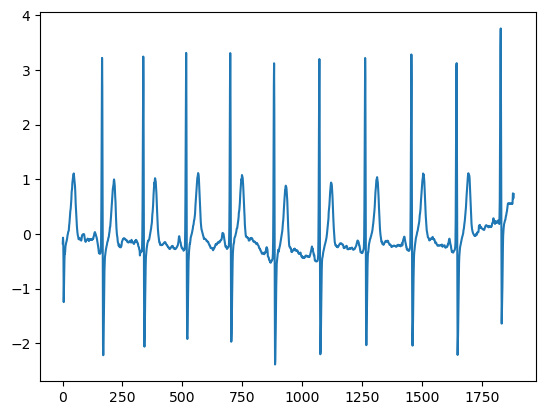

In [69]:
plt.plot(ECG_data.iloc[0, 1:-5]) # график экг после обработки сигнала

In [70]:
df_train = ECG_data_train.iloc[:, -5:]
df_val = ECG_data_val.iloc[:, -5:]

In [71]:
df_train

,patient_id,age,sex,height,weight
1592,4964.0,22.0,1,163.0,90.0
918,16196.0,84.0,0,NaN,NaN
122,767.0,61.0,0,183.0,83.0
684,12056.0,74.0,1,NaN,NaN
214,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN
1731,4102.0,64.0,1,168.0,66.0
763,10524.0,34.0,0,NaN,72.0
835,10717.0,55.0,0,NaN,NaN


In [45]:
ECG_data_train = ECG_data_train.iloc[:, :-5]
ECG_data_val = ECG_data_val.iloc[:, :-5]

In [46]:
ECG_data_train

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1592,16603,0.109449,0.185223,0.125672,-0.151371,-0.829218,-0.622236,-0.656209,-0.655158,-0.620203,...,-0.276397,-0.271167,-0.271356,-0.278988,-0.276562,-0.365569,-0.453599,-0.369220,-0.385059,-0.441318
918,9557,-1.490900,-1.394463,-1.459593,-1.758585,-2.413724,-2.193418,-1.980952,-1.772527,-1.498688,...,1.808763,1.794004,1.791578,1.824338,1.824525,2.338546,2.856921,2.381495,2.466389,2.781295
122,1511,0.410295,0.418111,0.411441,0.385160,0.316728,0.322976,0.268045,0.196556,0.132210,...,0.429139,0.419976,0.423895,0.435734,0.434976,0.667413,0.897665,0.677479,0.718923,0.865508
684,7125,-0.121402,-0.121375,-0.120977,-0.119733,-0.114203,-0.115726,-0.117201,-0.126269,-0.128501,...,0.680528,0.667779,0.672897,0.689272,0.687265,0.994409,1.308699,1.007843,1.064270,1.265372
214,2316,0.028528,-0.025202,0.009788,0.172212,0.546162,0.536875,1.251363,2.411523,3.051960,...,-0.384466,-0.378909,-0.380860,-0.388554,-0.387973,-0.530641,-0.673326,-0.537565,-0.562936,-0.653343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,10677,1.348874,1.394465,1.405025,1.479370,1.920034,1.547778,0.474275,-0.755991,-1.562751,...,-0.187951,-0.184040,-0.186707,-0.190465,-0.189940,-0.280883,-0.378106,-0.283582,-0.301543,-0.365178
1731,18020,-0.285911,-0.265134,-0.282379,-0.365458,-0.574443,-0.503349,-0.498727,-0.482626,-0.459739,...,-0.247702,-0.239041,-0.247471,-0.255108,-0.257066,-0.526102,-0.801259,-0.535676,-0.586126,-0.763746
763,7978,-0.316812,-0.305549,-0.314139,-0.357382,-0.462342,-0.426322,-0.437142,-0.429418,-0.412790,...,-0.151037,-0.149981,-0.150161,-0.152364,-0.152745,-0.197529,-0.242362,-0.200993,-0.208471,-0.235857
835,8797,-0.897106,-0.901242,-0.897541,-0.887869,-0.862189,-0.857458,-0.841005,-0.826645,-0.800221,...,0.142141,0.140497,0.141669,0.143489,0.143677,0.191975,0.240699,0.193946,0.202788,0.233976


## N-граммы

In [28]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from catboost import CatBoostClassifier

In [47]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [48]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [49]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [50]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [51]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [52]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [53]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [54]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    # н-граммы, встречающиеся только в этой категории
    ng_healthy = sum(list(map(lambda x: 1 if x in only_healthy else 0, ng))) 
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))
    
    ng_septal_0 = sum(list(map(lambda x: 1 if x in only_septal_0 else 0, ng)))
    ng_septal_1 = sum(list(map(lambda x: 1 if x in only_septal_1 else 0, ng)))
    
    ng_front_0 = sum(list(map(lambda x: 1 if x in only_front_0 else 0, ng)))
    ng_front_1 = sum(list(map(lambda x: 1 if x in only_front_1 else 0, ng)))
    
    ng_side_0 = sum(list(map(lambda x: 1 if x in only_side_0 else 0, ng)))
    ng_side_1 = sum(list(map(lambda x: 1 if x in only_side_1 else 0, ng)))
    
    ng_front_side_0 = sum(list(map(lambda x: 1 if x in only_front_side_0 else 0, ng)))
    ng_front_side_1 = sum(list(map(lambda x: 1 if x in only_front_side_1 else 0, ng)))
    
    ng_front_septal_0 = sum(list(map(lambda x: 1 if x in only_front_septal_0 else 0, ng)))
    ng_front_septal_1 = sum(list(map(lambda x: 1 if x in only_front_septal_1 else 0, ng)))
    
    ng_lower_0 = sum(list(map(lambda x: 1 if x in only_lower_0 else 0, ng)))
    ng_lower_1 = sum(list(map(lambda x: 1 if x in only_lower_1 else 0, ng)))
    
    # н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
    ng_popular_healthy = sum(list(map(lambda x: 1 if x in popular_healthy_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))
    
    ng_popular_septal_0 = sum(list(map(lambda x: 1 if x in popular_septal_0_only else 0, ng)))
    ng_popular_septal_1 = sum(list(map(lambda x: 1 if x in popular_septal_1_only else 0, ng)))
    
    ng_popular_front_0 = sum(list(map(lambda x: 1 if x in popular_front_0_only else 0, ng)))
    ng_popular_front_1 = sum(list(map(lambda x: 1 if x in popular_front_1_only else 0, ng)))
    
    ng_popular_side_0 = sum(list(map(lambda x: 1 if x in popular_side_0_only else 0, ng)))
    ng_popular_side_1 = sum(list(map(lambda x: 1 if x in popular_side_1_only else 0, ng)))
    
    ng_popular_front_side_0 = sum(list(map(lambda x: 1 if x in popular_front_side_0_only else 0, ng)))
    ng_popular_front_side_1 = sum(list(map(lambda x: 1 if x in popular_front_side_1_only else 0, ng)))
    
    ng_popular_front_septal_0 = sum(list(map(lambda x: 1 if x in popular_front_septal_0_only else 0, ng)))
    ng_popular_front_septal_1 = sum(list(map(lambda x: 1 if x in popular_front_septal_1_only else 0, ng)))
    
    ng_popular_lower_0 = sum(list(map(lambda x: 1 if x in popular_lower_0_only else 0, ng)))
    ng_popular_lower_1 = sum(list(map(lambda x: 1 if x in popular_lower_1_only else 0, ng)))
    
    return array([[ng_healthy, ng_popular_healthy, ng_sick, ng_popular_sick],
                  [ng_septal_0, ng_popular_septal_0, ng_septal_1, ng_popular_septal_1],
                  [ng_front_0, ng_popular_front_0, ng_front_1, ng_popular_front_1],
                  [ng_side_0, ng_popular_side_0, ng_side_1, ng_popular_side_1],
                  [ng_front_side_0, ng_popular_front_side_0, ng_front_side_1, ng_popular_front_side_1],
                  [ng_front_septal_0, ng_popular_front_septal_0, ng_front_septal_1, ng_popular_front_septal_1],
                  [ng_lower_0, ng_popular_lower_0, ng_lower_1, ng_popular_lower_1]])

In [55]:
def sp_n_gramms(ngramma):  # получение н-грамм
    sp = []
    for i in ngramma:
        n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 4))))
        for k in n:
            sp.append(k)
    return sp

In [56]:
ECG_data_array_train = np.array(ECG_data_train)

In [57]:
R_Peaks_train = []

In [58]:
ecg_ids_train = []
encoding_ecgs_train = []

In [61]:
for ecgsignal in ECG_data_array_train: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_train.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_train.append(ecg_id)
    encoding_ecgs_train.append(encoding_ecg)

In [62]:
encoding_ecg_train = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_train.encoding_ecg = encoding_ecgs_train
encoding_ecg_train.ecg_id = ecg_ids_train
encoding_ecg_train = encoding_ecg_train.sort_values(by='ecg_id')
encoding_ecg_train[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_train)
encoding_ecg_train

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1027,DDCADDCC,9.0,0,0,0,0,0,0,1
189,BFABCFADDEC,43.0,0,0,0,0,0,0,1
1064,DDEFBCCBCCF,52.0,0,0,0,0,0,0,1
43,DDCADBCDD,57.0,0,0,0,0,0,0,1
1110,FFCCFDCFDA,96.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
365,EBDCEBDCEB,21756.0,0,0,0,0,0,0,1
181,BCEFCCDDFAF,21774.0,0,0,0,0,0,0,1
344,AEDDDCCD,21775.0,0,0,0,0,0,0,1
1389,ECCDDDECB,21825.0,0,1,0,0,0,0,0


In [63]:
encoding_ecg_train.норма.sum()

1269

In [64]:
healthy = encoding_ecg_train[encoding_ecg_train['норма'] == 1].encoding_ecg  # закодированные кардиограммы по категориям
sick = encoding_ecg_train[encoding_ecg_train['норма'] == 0].encoding_ecg

septal_0 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 0].encoding_ecg
septal_1 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 1].encoding_ecg

front_0 = encoding_ecg_train[encoding_ecg_train['передний'] == 0].encoding_ecg
front_1 = encoding_ecg_train[encoding_ecg_train['передний'] == 1].encoding_ecg

side_0 = encoding_ecg_train[encoding_ecg_train['боковой'] == 0].encoding_ecg
side_1 = encoding_ecg_train[encoding_ecg_train['боковой'] == 1].encoding_ecg

front_side_0 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 0].encoding_ecg
front_side_1 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 1].encoding_ecg

front_septal_0 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 0].encoding_ecg
front_septal_1 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 1].encoding_ecg

lower_0 = encoding_ecg_train[encoding_ecg_train['нижний'] == 0].encoding_ecg
lower_1 = encoding_ecg_train[encoding_ecg_train['нижний'] == 1].encoding_ecg

In [65]:
sp_healthy = sp_n_gramms(healthy)  # списки н-грамм
sp_sick = sp_n_gramms(sick)

sp_septal_0 = sp_n_gramms(septal_0)
sp_septal_1 = sp_n_gramms(septal_1)

sp_front_0 = sp_n_gramms(front_0)
sp_front_1 = sp_n_gramms(front_1)

sp_side_0 = sp_n_gramms(side_0)
sp_side_1 = sp_n_gramms(side_1)

sp_front_side_0 = sp_n_gramms(front_side_0)
sp_front_side_1 = sp_n_gramms(front_side_1)

sp_front_septal_0 = sp_n_gramms(front_septal_0)
sp_front_septal_1 = sp_n_gramms(front_septal_1)

sp_lower_0 = sp_n_gramms(lower_0)
sp_lower_1 = sp_n_gramms(lower_1)

In [66]:
q_healthy = counter_and_sort(sp_healthy)  # отсортированные н-граммы
q_sick = counter_and_sort(sp_sick)

q_septal_0 = counter_and_sort(sp_septal_0)
q_septal_1 = counter_and_sort(sp_septal_1)

q_front_0 = counter_and_sort(sp_front_0)
q_front_1 = counter_and_sort(sp_front_1)

q_side_0 = counter_and_sort(sp_side_0)
q_side_1 = counter_and_sort(sp_side_1)

q_front_side_0 = counter_and_sort(sp_front_side_0)
q_front_side_1 = counter_and_sort(sp_front_side_1)

q_front_septal_0 = counter_and_sort(sp_front_septal_0)
q_front_septal_1 = counter_and_sort(sp_front_septal_1)

q_lower_0 = counter_and_sort(sp_lower_0)
q_lower_1 = counter_and_sort(sp_lower_1)

In [67]:
only_sick = list(set(q_sick.index) - set(q_healthy.index))  # н-граммы, встречающиеся только в этой категории 
only_healthy = list(set(q_healthy.index) - set(q_sick.index))

only_septal_0 = list(set(q_septal_0.index) - set(q_septal_1.index))
only_septal_1 = list(set(q_septal_1.index) - set(q_septal_0.index))

only_front_0 = list(set(q_front_0.index) - set(q_front_1.index))
only_front_1 = list(set(q_front_1.index) - set(q_front_0.index))

only_side_0 = list(set(q_side_0.index) - set(q_side_1.index))
only_side_1 = list(set(q_side_1.index) - set(q_side_0.index))

only_front_side_0 = list(set(q_front_side_0.index) - set(q_front_side_1.index))
only_front_side_1 = list(set(q_front_side_1.index) - set(q_front_side_0.index))

only_front_septal_0 = list(set(q_front_septal_0.index) - set(q_front_septal_1.index))
only_front_septal_1 = list(set(q_front_septal_1.index) - set(q_front_septal_0.index))

only_lower_0 = list(set(q_lower_0.index) - set(q_lower_1.index))
only_lower_1 = list(set(q_lower_1.index) - set(q_lower_0.index))

In [68]:
popular_sick = q_sick.iloc[:len(q_sick) // 2]  # н-граммы, чаще всего встречающиеся в этой категории
popular_healthy = q_healthy.iloc[:len(q_healthy) // 2]

popular_septal_0 = q_septal_0.iloc[:len(q_septal_0) // 2]
popular_septal_1 = q_septal_1.iloc[:len(q_septal_1) // 2]

popular_front_0 = q_front_0.iloc[:len(q_front_0) // 2]
popular_front_1 = q_front_1.iloc[:len(q_front_1) // 2]

popular_side_0 = q_side_0.iloc[:len(q_side_0) // 2]
popular_side_1 = q_side_1.iloc[:len(q_side_1) // 2]

popular_front_side_0 = q_front_side_0.iloc[:len(q_front_side_0) // 2]
popular_front_side_1 = q_front_side_1.iloc[:len(q_front_side_1) // 2]

popular_front_septal_0 = q_front_septal_0.iloc[:len(q_front_septal_0) // 2]
popular_front_septal_1 = q_front_septal_1.iloc[:len(q_front_septal_1) // 2]

popular_lower_0 = q_lower_0.iloc[:len(q_lower_0) // 2]
popular_lower_1 = q_lower_1.iloc[:len(q_lower_1) // 2]

In [69]:
# н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
popular_sick_only = list(set(popular_sick.index) - set(popular_healthy.index))
popular_healthy_only = list(set(popular_healthy.index) - set(popular_sick.index))

popular_septal_0_only = list(set(popular_septal_0.index) - set(popular_septal_1.index))
popular_septal_1_only = list(set(popular_septal_1.index) - set(popular_septal_0.index))

popular_front_0_only = list(set(popular_front_0.index) - set(popular_front_1.index))
popular_front_1_only = list(set(popular_front_1.index) - set(popular_front_0.index))

popular_side_0_only = list(set(popular_side_0.index) - set(popular_side_1.index))
popular_side_1_only = list(set(popular_side_1.index) - set(popular_side_0.index))

popular_front_side_0_only = list(set(popular_front_side_0.index) - set(popular_front_side_1.index))
popular_front_side_1_only = list(set(popular_front_side_1.index) - set(popular_front_side_0.index))

popular_front_septal_0_only = list(set(popular_front_septal_0.index) - set(popular_front_septal_1.index))
popular_front_septal_1_only = list(set(popular_front_septal_1.index) - set(popular_front_septal_0.index))

popular_lower_0_only = list(set(popular_lower_0.index) - set(popular_lower_1.index))
popular_lower_1_only = list(set(popular_lower_1.index) - set(popular_lower_0.index))

In [70]:
ngramms_ecgs_train = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_train):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 4))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs_train.append(list(ngramms_ecg))

In [71]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_train])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_train])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_train])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_train])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_train])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_train])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_train])

In [72]:
df_septal

,0,1,2,3
0,4.0,4.0,0.0,0.0
1,6.0,3.0,0.0,1.0
2,7.0,4.0,0.0,1.0
3,3.0,4.0,0.0,0.0
4,3.0,5.0,0.0,0.0
...,...,...,...,...
1570,2.0,3.0,0.0,0.0
1571,4.0,6.0,0.0,0.0
1572,4.0,4.0,0.0,0.0
1573,3.0,5.0,0.0,0.0


In [73]:
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(df_healthy,
                                                                    myocard_train['норма'], random_state=0, test_size=0.8)

X_train_septal, X_test_septal, y_train_septal, y_test_septal = train_test_split(df_septal, myocard_train['перегородочный'],
                                                                                random_state=0, test_size=0.35)

X_train_front, X_test_front, y_train_front, y_test_front = train_test_split(df_front, myocard_train['передний'],
                                                                            random_state=0, test_size=0.7)

X_train_side, X_test_side, y_train_side, y_test_side = train_test_split(df_side, myocard_train['боковой'], random_state=0)

X_train_front_side, X_test_front_side, y_train_front_side, y_test_front_side = train_test_split(df_front_side,
                                                                    myocard_train['передне-боковой'], random_state=0,
                                                                                               test_size=0.1)

X_train_front_septal, X_test_front_septal, y_train_front_septal, y_test_front_septal = train_test_split(df_front_septal,
                                                                    myocard_train['передне-перегородочный'], random_state=0,
                                                                                                       test_size=0.2)

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(df_lower, myocard_train['нижний'],
                                                                            random_state=0, test_size=0.45)

In [74]:
cat_n_gramms_healthy = CatBoostClassifier()
cat_n_gramms_healthy.fit(X_train_healthy, y_train_healthy, verbose=False)

In [75]:
print(f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro'))
print(f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro'))

0.7103710796656855
0.7736777141172786


In [76]:
cat_n_gramms_septal = CatBoostClassifier()
cat_n_gramms_septal.fit(X_train_septal, y_train_septal, verbose=False)

In [77]:
print(f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro'))
print(f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro'))

0.7339759036144579
0.8523071797434616


In [78]:
cat_n_gramms_front = CatBoostClassifier()
cat_n_gramms_front.fit(X_train_front, y_train_front, verbose=False)

In [79]:
print(f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro'))
print(f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro'))

0.8494608980483145
0.8586967368526096


In [81]:
cat_n_gramms_side = CatBoostClassifier()
cat_n_gramms_side.fit(X_train_side, y_train_side, verbose=False)

In [82]:
print(f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro'))
print(f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro'))

1.0
1.0


In [83]:
cat_n_gramms_front_side = CatBoostClassifier()
cat_n_gramms_front_side.fit(X_train_front_side, y_train_front_side, verbose=False)

In [84]:
print(f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro'))
print(f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro'))

1.0
0.8858481120458495


In [85]:
cat_n_gramms_front_septal = CatBoostClassifier()
cat_n_gramms_front_septal.fit(X_train_front_septal, y_train_front_septal, verbose=False)

In [86]:
print(f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro'))
print(f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro'))

0.8275862068965516
0.7537946882180988


In [88]:
cat_n_gramms_lower = CatBoostClassifier()
cat_n_gramms_lower.fit(X_train_lower, y_train_lower, verbose=False)

In [89]:
print(f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro'))
print(f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro'))

0.6832464631422189
0.7194117618612388


In [90]:
print((f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro') +
       f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro') + 
      f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro') + 
      f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro') +
      f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro') + 
      f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro') + 
      f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro')) / 7)

0.8292343644810326


In [91]:
print((f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro') +
       f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro') + 
      f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro') + 
      f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro') +
      f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro') + 
      f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro') + 
      f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro')) / 7)

0.8348194561197909


## Валидационная выборка (н-граммы)

In [468]:
ECG_data_val

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1135,11747,-0.039802,0.081263,-0.001716,-0.382304,-1.234458,-0.989706,-0.992901,-1.007916,-0.990175,...,0.926767,0.912089,0.892417,0.937878,0.927163,1.249608,1.566814,1.293455,1.337666,1.516719
1285,13244,0.011148,0.057131,0.023742,-0.131472,-0.492846,-0.379566,-0.367739,-0.355196,-0.337555,...,-0.043018,-0.042389,-0.041891,-0.043569,-0.043474,-0.061216,-0.074842,-0.062777,-0.064920,-0.072557
1317,13550,-0.442519,-0.497256,-0.464688,-0.317163,-0.013555,-0.057559,0.211902,0.384145,0.580323,...,-0.360194,-0.356257,-0.364051,-0.361705,-0.361774,-0.432236,-0.519593,-0.426768,-0.445986,-0.510038
1171,12046,0.285150,0.270425,0.279589,0.323485,0.413036,0.372710,0.287300,0.173588,0.047603,...,-0.048393,-0.052389,-0.053289,-0.046140,-0.047900,0.026828,0.093714,0.031293,0.042750,0.083690
1629,17010,0.278211,0.316438,0.288177,0.158055,-0.148968,-0.060007,-0.079030,-0.094451,-0.101068,...,0.139427,0.135820,0.136371,0.141821,0.140881,0.222921,0.305317,0.227227,0.241696,0.293725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,3326,-0.168572,-0.163014,-0.167406,-0.190103,-0.251889,-0.251091,-0.406968,-0.423865,-0.410163,...,0.135359,0.122823,0.132362,0.142246,0.140672,0.399231,0.650283,0.401454,0.450249,0.616537
572,6043,-0.126710,-0.063809,-0.111900,-0.336378,-0.877066,-0.710878,-0.735117,-0.740817,-0.716353,...,2.082263,2.026851,2.036850,2.117382,2.101671,3.311050,4.525750,3.370373,3.585263,4.355601
1858,19320,-0.040343,-0.009573,-0.034800,-0.153176,-0.449508,-0.356325,-0.370884,-0.361877,-0.341365,...,-0.138259,-0.140756,-0.138098,-0.135747,-0.134623,-0.044051,0.044768,-0.040289,-0.024214,0.032333
1693,17657,0.225451,0.198650,0.222838,0.333616,0.623670,0.533530,0.541476,0.526216,0.498645,...,-0.076187,-0.071718,-0.078512,-0.081033,-0.084876,-0.266705,-0.429813,-0.271544,-0.302457,-0.406626


In [469]:
myocard_val

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [470]:
ECG_data_val_array = np.array(ECG_data_val)
R_Peaks_val = []
ecg_ids_val = []
encoding_ecgs_val = []

In [471]:
for ecgsignal in ECG_data_val_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_val.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_val.append(ecg_id)
    encoding_ecgs_val.append(encoding_ecg)

In [472]:
encoding_ecg_val = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_val.encoding_ecg = encoding_ecgs_val
encoding_ecg_val.ecg_id = ecg_ids_val
encoding_ecg_val = encoding_ecg_val.sort_values(by='ecg_id')
encoding_ecg_val[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_val)
encoding_ecg_val

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
510,DDDCCCFFFDDFCCCACFE,34.0,0,0,0,0,1,0,0
464,DDBBCCDDA,61.0,0,0,0,0,0,0,1
193,CAFCBADDC,81.0,0,0,0,0,0,0,1
266,BEBCEDBDEC,109.0,0,0,0,0,0,1,0
422,BDDCEDFCDE,115.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
74,AAFDDFCCAF,21672.0,0,0,0,0,0,0,1
27,CFCDAFCD,21712.0,0,0,0,0,0,0,1
411,DDCCFFAFAFFAFC,21784.0,0,0,0,0,0,0,1
300,,21795.0,0,0,0,0,0,0,1


In [473]:
ngramms_ecgs_val = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_val):
    ngramms_ecg_val = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 4))))
    for k in n:
        ngramms_ecg_val.add(k)
    ngramms_ecgs_val.append(list(ngramms_ecg_val))

In [474]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_val])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_val])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_val])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_val])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_val])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_val])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_val])

In [475]:
print((f1_score(myocard_val['норма'], cat_n_gramms_healthy.predict(df_healthy), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_n_gramms_septal.predict(df_septal), average='macro') + 
        f1_score(myocard_val['передний'], cat_n_gramms_front.predict(df_front), average='macro') + 
         f1_score(myocard_val['боковой'], cat_n_gramms_side.predict(df_side), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_n_gramms_front_side.predict(df_front_side), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_n_gramms_front_septal.predict(df_front_septal), average='macro') +
            f1_score(myocard_val['нижний'], cat_n_gramms_lower.predict(df_lower), average='macro')) / 7)

0.5623875930620502


In [477]:
answer_val = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
                              'нижний', 'норма'])

In [478]:
answer_val['норма'] = cat_n_gramms_healthy.predict(df_healthy)
answer_val['перегородочный'] = cat_n_gramms_septal.predict(df_septal)
answer_val['передний'] = cat_n_gramms_front.predict(df_front)
answer_val['боковой'] = cat_n_gramms_side.predict(df_side)
answer_val['передне-боковой'] = cat_n_gramms_front_side.predict(df_front_side)
answer_val['передне-перегородочный'] = cat_n_gramms_front_septal.predict(df_front_septal)
answer_val['нижний'] = cat_n_gramms_lower.predict(df_lower)

In [479]:
answer_val.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,526.0,526.000000,526.0,526.000000,526.000000,526.000000,526.000000
mean,0.0,0.001901,0.0,0.003802,0.009506,0.026616,0.958175
std,0.0,0.043602,0.0,0.061604,0.097125,0.161111,0.200380
min,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
50%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
75%,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.000000
max,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000


## Тестовая выборка (н-граммы)

In [480]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [481]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [482]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [483]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [484]:
df_test = pd.read_csv('test/test_meta.csv')
df_test.record_name = list(map(lambda x: int(x.strip('_hr')), df_test.record_name))

In [485]:
df_test.rename(columns = {'record_name':'ecg_id'}, inplace = True)

In [486]:
ECG_data_test = ECG_data_test.merge(df_test, on='ecg_id', how='left')

In [487]:
df_test = ECG_data_test.iloc[:, -5:]
ECG_data_test = ECG_data_test.iloc[:, :-5]

In [488]:
df_test

,patient_id,age,sex,height,weight
0,11926.0,22.0,1,NaN,52.0
1,12396.0,60.0,1,NaN,NaN
2,17536.0,28.0,0,NaN,112.0
3,21074.0,19.0,1,NaN,59.0
4,18690.0,85.0,1,NaN,NaN
...,...,...,...,...,...
444,8951.0,44.0,0,NaN,NaN
445,21392.0,71.0,0,NaN,NaN
446,17212.0,62.0,1,NaN,NaN
447,13332.0,40.0,0,NaN,NaN


In [489]:
ECG_data_test_array = np.array(ECG_data_test)
R_Peaks_test = []
ecg_ids_test = []
encoding_ecgs_test = []

In [490]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [491]:
encoding_ecg_test = pd.DataFrame(columns=['encoding_ecg', 'ecg_id'])
encoding_ecg_test.encoding_ecg = encoding_ecgs_test
encoding_ecg_test.ecg_id = ecg_ids_test
encoding_ecg_test

,encoding_ecg,ecg_id
0,DCCBDDFCCB,127.0
1,DBEBFA,186.0
2,CCCFDDEABCFC,193.0
3,ADBEDECCD,198.0
4,,211.0
...,...,...
444,DBFEABC,21269.0
445,DFFACFCDFDCCC,21301.0
446,DBCEFAFAFCF,21366.0
447,CDBBCED,21547.0


In [492]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 4))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [493]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_test])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_test])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_test])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_test])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_test])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_test])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_test])

In [494]:
answer = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
                              'нижний', 'норма', 'record_name'])

In [495]:
answer['record_name'] = list(map(lambda x: x[:-4], os.listdir('test')[:-1]))
answer['норма'] = cat_n_gramms_healthy.predict(df_healthy)
answer['перегородочный'] = cat_n_gramms_septal.predict(df_septal)
answer['передний'] = cat_n_gramms_front.predict(df_front)
answer['боковой'] = cat_n_gramms_side.predict(df_side)
answer['передне-боковой'] = cat_n_gramms_front_side.predict(df_front_side)
answer['передне-перегородочный'] = cat_n_gramms_front_septal.predict(df_front_septal)
answer['нижний'] = cat_n_gramms_lower.predict(df_lower)

In [498]:
answer.to_csv('answer.csv',index=False)

In [403]:
answer.describe() # 4-граммы

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,449.000000,449.0,449.0,449.0,449.000000,449.000000,449.000000
mean,0.008909,0.0,0.0,0.0,0.011136,0.002227,0.942094
std,0.094069,0.0,0.0,0.0,0.105054,0.047193,0.233827
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
75%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
max,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


In [497]:
answer.describe() # 7-граммы

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,449.000000,449.0,449.0,449.0,449.000000,449.000000,449.000000
mean,0.004454,0.0,0.0,0.0,0.015590,0.015590,0.962138
std,0.066666,0.0,0.0,0.0,0.124022,0.124022,0.191075
min,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
75%,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000
max,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000


## Анализ метаданных

In [74]:
myocard_train_meta = myocard_train.copy()

In [75]:
myocard_train_meta

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1592,0,0,0,0,0,0,1
918,0,0,0,0,0,0,1
122,0,0,0,0,0,0,1
684,0,0,0,0,0,0,1
214,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1033,0,0,0,0,0,0,1
1731,0,0,0,0,0,0,1
763,0,0,0,0,0,0,1
835,0,1,0,0,0,0,0


In [82]:
df_train_enc = df_train.copy()

In [83]:
combo_info = df_train_enc['weight'].astype(str) + '_' + df_train_enc['height'].astype(str) \
    + '_' + df_train_enc['age'].astype(str) + '_' + df_train_enc['sex'].astype(str)
df_train_enc.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [84]:
df_train_enc.drop(['weight', 'height', 'age', 'sex', 'patient_id'], axis= 1 , inplace= True)
df_train_enc

,combo_info
1592,90.0_163.0_22.0_1
918,nan_nan_84.0_0
122,83.0_183.0_61.0_0
684,nan_nan_74.0_1
214,nan_152.0_60.0_1
...,...
1033,nan_nan_49.0_0
1731,66.0_168.0_64.0_1
763,72.0_nan_34.0_0
835,nan_nan_55.0_0


In [85]:
df_train_healthy_enc = df_train_enc.copy()
#норма
df_train_septal_enc = df_train_enc.copy()
#перегородочный
df_train_front_enc = df_train_enc.copy()
#передний
df_train_side_enc = df_train_enc.copy()
#боковой
df_train_front_side_enc = df_train_enc.copy()
#передне-боковой
df_train_front_septal_enc = df_train_enc.copy()
#передне-перегородочный
df_train_lower_enc = df_train_enc.copy()
#нижний

In [86]:
target_encoder_healthy = TargetEncoder()
target_encoder_healthy.fit(df_train_healthy_enc.combo_info, myocard_train_meta['норма'])
target_encoded_healthy = target_encoder_healthy.transform(df_train_healthy_enc.combo_info)
df_train_healthy_enc.combo_info = target_encoded_healthy.astype('float')

target_encoder_septal = TargetEncoder()
target_encoder_septal.fit(df_train_septal_enc.combo_info, myocard_train_meta['перегородочный'])
target_encoded_septal = target_encoder_septal.transform(df_train_septal_enc.combo_info)
df_train_septal_enc.combo_info = target_encoded_septal.astype('float')

target_encoder_front = TargetEncoder()
target_encoder_front.fit(df_train_front_enc.combo_info, myocard_train_meta['передний'])
target_encoded_front = target_encoder_front.transform(df_train_front_enc.combo_info)
df_train_front_enc.combo_info = target_encoded_front.astype('float')

target_encoder_side_enc = TargetEncoder()
target_encoder_side_enc.fit(df_train_side_enc.combo_info, myocard_train_meta['боковой'])
target_encoded_side_enc = target_encoder_side.transform(df_train_side_enc.combo_info)
df_train_side_enc.combo_info = target_encoded_side.astype('float')

target_encoder_front_side = TargetEncoder()
target_encoder_front_side.fit(df_train_front_side_enc.combo_info, myocard_train_meta['передне-боковой'])
target_encoded_front_side = target_encoder_front_side.transform(df_train_front_side_enc.combo_info)
df_train_front_side_enc.combo_info = target_encoded_front_side.astype('float')

target_encoder_front_septal = TargetEncoder()
target_encoder_front_septal.fit(df_train_front_septal_enc.combo_info, myocard_train_meta['передне-перегородочный'])
target_encoded_front_septal = target_encoder_front_septal.transform(df_train_front_septal_enc.combo_info)
df_train_front_septal_enc.combo_info = target_encoded_front_septal.astype('float')

target_encoder_lower = TargetEncoder()
target_encoder_lower.fit(df_train_lower_enc.combo_info, myocard_train_meta['нижний'])
target_encoded_lower = target_encoder_lower.transform(df_train_lower_enc.combo_info)
df_train_lower_enc.combo_info = target_encoded_lower.astype('float')

In [87]:
X_train_healthy_enc, X_test_healthy_enc, y_train_healthy_enc, y_test_healthy_enc = train_test_split(df_train_healthy_enc, 
                                                                myocard_train_meta['норма'], train_size=0.99, random_state=0)

X_train_septal_enc, X_test_septal_enc, y_train_septal_enc, y_test_septal_enc = train_test_split(df_train_septal_enc, 
                                                                myocard_train_meta['перегородочный'], train_size=0.99, random_state=0)

X_train_front_enc, X_test_front_enc, y_train_front_enc, y_test_front_enc = train_test_split(df_train_front_enc, 
                                                                myocard_train_meta['передний'], train_size=0.99, random_state=0)

X_train_side_enc, X_test_side_enc, y_train_side_enc, y_test_side_enc = train_test_split(df_train_side_enc, 
                                                                myocard_train_meta['боковой'], train_size=0.99, random_state=0)

X_train_front_side_enc, X_test_front_side_enc, y_train_front_side_enc, y_test_front_side_enc = train_test_split(df_train_front_side_enc, 
                                                                myocard_train_meta['передне-боковой'], train_size=0.99, random_state=0)

X_train_front_septal_enc, X_test_front_septal_enc, y_train_front_septal_enc, y_test_front_septal_enc = train_test_split(df_train_front_septal_enc, 
                                                                myocard_train_meta['передне-перегородочный'], train_size=0.99, random_state=0)

X_train_lower_enc, X_test_lower_enc, y_train_lower_enc, y_test_lower_enc = train_test_split(df_train_lower_enc, 
                                                                myocard_train_meta['нижний'], train_size=0.99, random_state=0)

In [88]:
cat_healthy = CatBoostClassifier()
cat_healthy.fit(X_train_healthy_enc, y_train_healthy_enc, verbose=False)

In [89]:
print(f1_score(y_train_healthy_enc, cat_healthy.predict(X_train_healthy_enc), average = 'macro'))
print(f1_score(y_test_healthy_enc, cat_healthy.predict(X_test_healthy_enc), average = 'macro'))

0.7356346899224806
0.8814814814814815


In [90]:
cat_septal = CatBoostClassifier()
cat_septal.fit(X_train_septal_enc, y_train_septal_enc, verbose=False)

In [91]:
print(f1_score(y_train_septal_enc, cat_septal.predict(X_train_septal_enc), average = 'macro'))
print(f1_score(y_test_septal_enc, cat_septal.predict(X_test_septal_enc), average = 'macro'))

0.8067500563443768
0.8160919540229885


In [92]:
cat_front = CatBoostClassifier()
cat_front.fit(X_train_front_enc, y_train_front_enc, verbose=False)

In [93]:
print(f1_score(y_train_front_enc, cat_front.predict(X_train_front_enc), average = 'macro'))
print(f1_score(y_test_front_enc, cat_front.predict(X_test_front_enc), average = 'macro'))

0.6739490661046671
1.0


In [ ]:
cat_side = CatBoostClassifier()
cat_side.fit(X_train_side_enc, y_train_side_enc, verbose=False)

In [ ]:
print(f1_score(y_train_side_enc, cat_side.predict(X_train_side_enc), average = 'macro'))
print(f1_score(y_test_side_enc, cat_side.predict(X_test_side_enc), average = 'macro'))

In [ ]:
cat_front_side = CatBoostClassifier()
cat_front_side.fit(X_train_front_side_enc, y_train_front_side_enc, verbose=False)

In [ ]:
print(f1_score(y_train_front_side_enc, cat_front_side.predict(X_train_front_side_enc), average = 'macro'))
print(f1_score(y_test_front_side_enc, cat_front_side.predict(X_test_front_side_enc), average = 'macro'))

In [45]:
cat_front_septal = CatBoostClassifier()
cat_front_septal.fit(X_train_front_septal_enc, y_train_front_septal_enc, verbose=False)

In [46]:
print(f1_score(y_train_front_septal_enc, cat_front_septal.predict(X_train_front_septal_enc), average = 'macro'))
print(f1_score(y_test_front_septal_enc, cat_front_septal.predict(X_test_front_septal_enc), average = 'macro'))

0.787480120280655
1.0


In [47]:
cat_lower = CatBoostClassifier()
cat_lower.fit(X_train_lower_enc, y_train_lower_enc, verbose=False)

In [48]:
print(f1_score(y_train_lower_enc, cat_lower.predict(X_train_lower_enc), average = 'macro'))
print(f1_score(y_test_lower_enc, cat_lower.predict(X_test_lower_enc), average = 'macro'))

0.7311011194560967
1.0


In [49]:
#тренировочные
print((f1_score(y_train_healthy_enc, cat_healthy.predict(X_train_healthy_enc), average = 'macro') +
       f1_score(y_train_septal_enc, cat_septal.predict(X_train_septal_enc), average = 'macro') + 
        f1_score(y_train_fron_enct, cat_front.predict(X_train_front_enc), average = 'macro') + 
         f1_score(y_train_side_enc, cat_side.predict(X_train_side_enc), average = 'macro') +
          f1_score(y_train_front_side_enc, cat_front_side.predict(X_train_front_side_enc), average = 'macro') +
           f1_score(y_train_front_septal_enc, cat_front_septal.predict(X_train_front_septal_enc), average = 'macro') +
            f1_score(y_train_lower_enc, cat_lower.predict(X_train_lower_enc), average = 'macro')) / 7)

0.7566561708158253


In [50]:
#тестовые
print((f1_score(y_test_healthy_enc, cat_healthy.predict(X_test_healthy_enc), average = 'macro') +
       f1_score(y_test_septal_enc, cat_septal.predict(X_test_septal_enc), average = 'macro') + 
        f1_score(y_test_front_enc, cat_front.predict(X_test_front_enc), average = 'macro') + 
         f1_score(y_test_side_enc, cat_side.predict(X_test_side_enc), average = 'macro') +
          f1_score(y_test_front_side_enc, cat_front_side.predict(X_test_front_side_enc), average = 'macro') +
           f1_score(y_test_front_septal_enc, cat_front_septal.predict(X_test_front_septal_enc), average = 'macro') +
            f1_score(y_test_lower_enc, cat_lower.predict(X_test_lower_enc), average = 'macro')) / 7)

0.9567962050720672


In [51]:
data_analysis_train = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 
                                      'передне-перегородочный', 'нижний', 'норма'])

In [52]:
data_analysis_train['норма'] = cat_healthy.predict(df_train_healthy)
data_analysis_train['нижний'] = cat_lower.predict(df_train_lower)
data_analysis_train['передне-перегородочный'] = cat_front_septal.predict(df_train_front_septal)
data_analysis_train['передне-боковой'] = cat_front_side.predict(df_train_front_side)
data_analysis_train['боковой'] = cat_side.predict(df_train_side)
data_analysis_train['передний'] = cat_front.predict(df_train_front)
data_analysis_train['перегородочный'] = cat_septal.predict(df_train_septal)

In [53]:
data_analysis_train.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000,1575.000000
mean,0.012063,0.006984,0.000635,0.003810,0.023492,0.033651,0.918095
std,0.109204,0.083305,0.025198,0.061623,0.151508,0.180386,0.274307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
#класс мультиклассификатора
class MultiClassifier: 
  def __init__(self, classes): 
    self.models = dict() 
    self.classes = classes
    for i in classes: 
      self.models[i] = 0 
  def multifit(self, train, train_target): 
    for i in self.classes: 
      mod = CatBoostClassifier() 
      mod.fit(train, train_target[i]) 
      self.models[i] = mod 
  def train_score(self, train, train_target): 
    f1_scores = []
    for i in self.classes: 
      mod = self.models[i] 
      f1_scores.append(f1_score(train_target[i], mod.predict(train)))
    self.f1_train = np.array(f1_scores).mean()
  def val_score(self, val, val_target):
    f1_scores = [] 
    for i in self.classes: 
      mod = self.models[i] 
      f1_scores.append(f1_score(val_target[i], mod.predict(val)))
    self.f1_val = np.array(f1_scores).mean()
  def multipredict(self, data): 
    predicts = pd.DataFrame(columns=self.classes, index = range(data.shape[0])) 
    for i in self.classes: 
      mod = self.models[i]
      predicts[i] = mod.predict(data)
    return predicts

## Валидационная выборка (анализ метаданных)

In [176]:
myocard_val_meta = myocard_val.copy()

In [177]:
combo_info = df_val['weight'].astype(str) + '_' + df_val['height'].astype(str) \
    + '_' + df_val['age'].astype(str) + '_' + df_val['sex'].astype(str)
df_val.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [178]:
df_val.drop(['weight', 'height', 'age', 'sex', 'patient_id'], axis= 1 , inplace= True)

In [179]:
df_val_healthy = df_val.copy()
#норма
df_val_septal = df_val.copy()
#перегородочный
df_val_front = df_val.copy()
#передний
df_val_side = df_val.copy()
#боковой
df_val_front_side = df_val.copy()
#передне-боковой
df_val_front_septal = df_val.copy()
#передне-перегородочный
df_val_lower = df_val.copy()
#нижний

In [180]:
target_encoded_healthy = target_encoder_healthy.transform(df_val_healthy.combo_info)
df_val_healthy.combo_info = target_encoded_healthy.astype('float')

target_encoded_septal = target_encoder_septal.transform(df_val_septal.combo_info)
df_val_septal.combo_info = target_encoded_septal.astype('float')

target_encoded_front = target_encoder_front.transform(df_val_front.combo_info)
df_val_front.combo_info = target_encoded_front.astype('float')

target_encoded_side = target_encoder_side.transform(df_val_side.combo_info)
df_val_side.combo_info = target_encoded_side.astype('float')

target_encoded_front_side = target_encoder_front_side.transform(df_val_front_side.combo_info)
df_val_front_side.combo_info = target_encoded_front_side.astype('float')

target_encoded_front_septal = target_encoder_front_septal.transform(df_val_front_septal.combo_info)
df_val_front_septal.combo_info = target_encoded_front_septal.astype('float')

target_encoded_lower = target_encoder_lower.transform(df_val_lower.combo_info)
df_val_lower.combo_info = target_encoded_lower.astype('float')

In [181]:
print((f1_score(myocard_val['норма'], cat_healthy.predict(df_val_healthy), average='macro') +
       f1_score(myocard_val['перегородочный'], cat_septal.predict(df_val_septal), average='macro') + 
        f1_score(myocard_val['передний'], cat_front.predict(df_val_front), average='macro') + 
         f1_score(myocard_val['боковой'], cat_side.predict(df_val_side), average='macro') +
          f1_score(myocard_val['передне-боковой'], cat_front_side.predict(df_val_front_side), average='macro') +
           f1_score(myocard_val['передне-перегородочный'], cat_front_septal.predict(df_val_front_septal), average='macro') +
            f1_score(myocard_val['нижний'], cat_lower.predict(df_val_lower), average='macro')) / 7)

0.559558157251492


In [182]:
f1_score(myocard_val['норма'], cat_healthy.predict(df_val_healthy), average='macro')

0.4646527421257892

In [183]:
f1_score(myocard_val['перегородочный'], cat_septal.predict(df_val_septal), average='macro')

0.4922779922779923

In [184]:
f1_score(myocard_val['передний'], cat_front.predict(df_val_front), average='macro')

0.4976122254059217

In [185]:
f1_score(myocard_val['боковой'], cat_side.predict(df_val_side), average='macro')

1.0

In [186]:
f1_score(myocard_val['передне-боковой'], cat_front_side.predict(df_val_front_side), average='macro')

0.497131931166348

In [187]:
f1_score(myocard_val['передне-перегородочный'], cat_front_septal.predict(df_val_front_septal), average='macro')

0.48481880509304603

In [188]:
f1_score(myocard_val['нижний'], cat_lower.predict(df_val_lower), average='macro')

0.4804134046913471

In [131]:
data_analysis_val = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 
                                      'передне-перегородочный', 'нижний', 'норма'])

In [132]:
data_analysis_val['норма'] = cat_healthy.predict(df_val_healthy)

data_analysis_val['нижний'] = cat_lower.predict(df_val_lower)

data_analysis_val['передне-перегородочный'] = cat_front_septal.predict(df_val_front_septal)

data_analysis_val['передне-боковой'] = cat_front_side.predict(df_val_front_side)

data_analysis_val['боковой'] = cat_side.predict(df_val_side)

data_analysis_val['передний'] = cat_front.predict(df_val_front)

data_analysis_val['перегородочный'] = cat_septal.predict(df_val_septal)

In [133]:
data_analysis_val.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,526.0,526.0,526.0,526.0,526.0,526.000000,526.000000
mean,0.0,0.0,0.0,0.0,0.0,0.009506,0.980989
std,0.0,0.0,0.0,0.0,0.0,0.097125,0.136695
min,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
50%,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
75%,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000
max,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000


In [106]:
data_analysis_val.value_counts()

перегородочный  передний  боковой  передне-боковой  передне-перегородочный  нижний  норма
0               0         0        0                0                       0       1        516
                                                                                    0          5
                                                                            1       0          5
Name: count, dtype: int64

## Черновой вариант тестовой выборки (анализ метаданных)

In [61]:
df_test = pd.read_csv('test/test_meta.csv')
df_test

,patient_id,age,sex,height,weight,record_name
0,11926.0,22.0,1,NaN,52.0,00127_hr
1,12396.0,60.0,1,NaN,NaN,00186_hr
2,17536.0,28.0,0,NaN,112.0,00193_hr
3,21074.0,19.0,1,NaN,59.0,00198_hr
4,18690.0,85.0,1,NaN,NaN,00211_hr
...,...,...,...,...,...,...
444,8951.0,44.0,0,NaN,NaN,21269_hr
445,21392.0,71.0,0,NaN,NaN,21301_hr
446,17212.0,62.0,1,NaN,NaN,21366_hr
447,13332.0,40.0,0,NaN,NaN,21547_hr


In [62]:
combo_info = df_test['weight'].astype(str) + '_' + df_test['height'].astype(str) \
    + '_' + df_test['age'].astype(str) + '_' + df_test['sex'].astype(str)
df_test.insert(0, 'combo_info', combo_info)

df_test.drop(['weight', 'height', 'age', 'sex', 'patient_id', 'record_name'], axis= 1 , inplace= True)

In [63]:
df_test

,combo_info
0,52.0_nan_22.0_1
1,nan_nan_60.0_1
2,112.0_nan_28.0_0
3,59.0_nan_19.0_1
4,nan_nan_85.0_1
...,...
444,nan_nan_44.0_0
445,nan_nan_71.0_0
446,nan_nan_62.0_1
447,nan_nan_40.0_0


In [64]:
df_test_healthy = df_test.copy()
#норма
df_test_septal = df_test.copy()
#перегородочный
df_test_front = df_test.copy()
#передний
df_test_side = df_test.copy()
#боковой
df_test_front_side = df_test.copy()
#передне-боковой
df_test_front_septal = df_test.copy()
#передне-перегородочный
df_test_lower = df_test.copy()
#нижний

In [65]:
target_encoded_healthy = target_encoder_healthy.transform(df_test_healthy.combo_info)
df_test_healthy.combo_info = target_encoded_healthy.astype('float')

target_encoded_septal = target_encoder_septal.transform(df_test_septal.combo_info)
df_test_septal.combo_info = target_encoded_septal.astype('float')

target_encoded_front = target_encoder_front.transform(df_test_front.combo_info)
df_test_front.combo_info = target_encoded_front.astype('float')

target_encoded_side = target_encoder_side.transform(df_test_side.combo_info)
df_test_side.combo_info = target_encoded_side.astype('float')

target_encoded_front_side = target_encoder_front_side.transform(df_test_front_side.combo_info)
df_test_front_side.combo_info = target_encoded_front_side.astype('float')

target_encoded_front_septal = target_encoder_front_septal.transform(df_test_front_septal.combo_info)
df_test_front_septal.combo_info = target_encoded_front_septal.astype('float')

target_encoded_lower = target_encoder_lower.transform(df_test_lower.combo_info)
df_test_lower.combo_info = target_encoded_lower.astype('float')

In [118]:
data_analysis = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 
                                      'передне-перегородочный', 'нижний', 'норма'])

In [119]:
data_analysis['норма'] = cat_healthy.predict(df_test_healthy)

data_analysis['нижний'] = cat_lower.predict(df_test_lower)

data_analysis['передне-перегородочный'] = cat_front_septal.predict(df_test_front_septal)

data_analysis['передне-боковой'] = cat_front_side.predict(df_test_front_side)

data_analysis['боковой'] = cat_side.predict(df_test_side)

data_analysis['передний'] = cat_front.predict(df_test_front)

data_analysis['перегородочный'] = cat_septal.predict(df_test_septal)

In [120]:
data_analysis

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
444,0,0,0,0,0,0,1
445,0,0,0,0,0,0,1
446,0,0,0,0,0,0,1
447,0,0,0,0,0,0,1


In [121]:
data_analysis.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,449.0,449.0,449.0,449.0,449.000000,449.000000,449.000000
mean,0.0,0.0,0.0,0.0,0.002227,0.004454,0.977728
std,0.0,0.0,0.0,0.0,0.047193,0.066666,0.147730
min,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
50%,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
75%,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000
max,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000


## Анализ HRV-сигнала

In [92]:
def variational_range(peaks):
        f = np.zeros(len(peaks))
        for i in range(len(peaks) - 2):
            f[i] = abs(peaks[i + 1] - peaks[i]) / 10

        max_f = max(f)
        min = 0
        for m in range(len(f)):
            if f[min] > f[m] != 0:
                min = m

        delta_x = max_f - f[min]
        return delta_x

In [93]:
def func_moda_and_amplitude(peaks):
    eps = 0.02

    f = np.zeros(len(peaks))
    count_mode = np.zeros(len(peaks))

    for i in range(len(peaks) - 1):
        f[i] = (peaks[i + 1] - peaks[i])

    for m in range(len(f)):
        count = 0

        for t in range(len(f) - 1):
            if math.fabs(f[t + 1] - f[m]) / 1000 < eps:
                count += 1

        count_mode[m] = count
    max = len(peaks) - 1

    for m in range(len(count_mode)):
        if count_mode[max] < count_mode[m]:
            max = m
    return f[max] / 1000, 100 * count_mode[max] / len(peaks)

In [94]:
myocard_train_hrv = myocard_train.copy()
myocard_train_hrv

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1592,0,0,0,0,0,0,1
918,0,0,0,0,0,0,1
122,0,0,0,0,0,0,1
684,0,0,0,0,0,0,1
214,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
1033,0,0,0,0,0,0,1
1731,0,0,0,0,0,0,1
763,0,0,0,0,0,0,1
835,0,1,0,0,0,0,0


In [95]:
RR_train = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks_train))

In [96]:
M_train = list(map(lambda rr: pd.Series(rr).median(), RR_train))
myocard_train_hrv.insert(0, 'M', M_train)

In [97]:
myocard_train_hrv

,M,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1592,0.582524,0,0,0,0,0,0,1
918,0.428571,0,0,0,0,0,0,1
122,0.292690,0,0,0,0,0,0,1
684,0.368098,0,0,0,0,0,0,1
214,0.352953,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...
1033,0.371549,0,0,0,0,0,0,1
1731,0.364745,0,0,0,0,0,0,1
763,0.301508,0,0,0,0,0,0,1
835,0.750000,0,1,0,0,0,0,0


In [98]:
M_mean = myocard_train_hrv[myocard_train_hrv['норма'] == 1].M.mean() / 100000
myocard_train_hrv.M = myocard_train_hrv.M - M_mean

In [99]:
delta_x = list(map(lambda peaks: variational_range(peaks), R_Peaks_train))
myocard_train_hrv.insert(0, 'delta_x', delta_x)
delta_x_median = myocard_train_hrv[myocard_train_hrv['норма'] == 1].delta_x.median()
myocard_train_hrv.delta_x = myocard_train_hrv.delta_x - delta_x_median

In [100]:
moda_and_amplitude_train = pd.DataFrame(list(map(lambda peaks: func_moda_and_amplitude(peaks), R_Peaks_train)))

In [101]:
myocard_train_hrv.insert(0, 'moda', moda_and_amplitude_train.iloc[:, 0])
myocard_train_hrv.insert(0, 'amplitude', moda_and_amplitude_train.iloc[:, 1])

myocard_train_hrv.moda.fillna(0, inplace=True)
myocard_train_hrv.amplitude.fillna(0, inplace=True)

In [102]:
ivb_train = myocard_train_hrv.amplitude / myocard_train_hrv.delta_x
myocard_train_hrv.insert(0, 'ivb', ivb_train)

In [103]:
vri_train = 1 / (myocard_train_hrv.moda * myocard_train_hrv.delta_x)
myocard_train_hrv.insert(0, 'vri', vri_train)

In [104]:
X_train = myocard_train_hrv[['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri']]

In [105]:
myocard_train_hrv.drop(['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri'],
                       axis=1, inplace=True)

In [106]:
X_train

,M,delta_x,moda,amplitude,ivb,vri
1592,0.369754,-9.000000e-01,0.000,0.000000,-0.000000e+00,-inf
918,0.215801,-2.000000e-01,0.127,85.714286,-4.285714e+02,-3.937008e+01
122,0.079920,-2.000000e-01,0.131,86.666667,-4.333333e+02,-3.816794e+01
684,0.155328,3.200000e+00,0.237,50.000000,1.562500e+01,1.318565e+00
214,0.140183,-1.776357e-15,0.185,81.818182,-4.605954e+16,-3.042973e+15
...,...,...,...,...,...,...
1033,0.158779,-8.000000e-01,0.189,80.000000,-1.000000e+02,-6.613757e+00
1731,0.151975,-1.200000e+00,0.000,0.000000,-0.000000e+00,-inf
763,0.088737,5.200000e+00,0.159,83.333333,1.602564e+01,1.209482e+00
835,0.537230,1.310000e+01,0.175,81.818182,6.245663e+00,4.362050e-01


In [119]:
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(X_train, myocard_train_hrv['норма'],
                                                                                    random_state=0, test_size=0.91)

X_train_septal, X_test_septal, y_train_septal, y_test_septal = train_test_split(X_train,
                                                                                myocard_train_hrv['перегородочный'],
                                                                                    random_state=0, test_size=0.7)

X_train_front, X_test_front, y_train_front, y_test_front = train_test_split(X_train, myocard_train_hrv['передний'],
                                                                                    random_state=0, test_size=0.5)

X_train_side, X_test_side, y_train_side, y_test_side = train_test_split(X_train, myocard_train_hrv['боковой'],
                                                                         random_state=0)

X_train_front_side, X_test_front_side, y_train_front_side, y_test_front_side = train_test_split(X_train,
                                                                                myocard_train_hrv['передне-боковой'],
                                                                                    random_state=0, test_size=0.7)

X_train_front_septal, X_test_front_septal, y_train_front_septal, y_test_front_septal = train_test_split(X_train,
                                                                                myocard_train_hrv['передне-перегородочный'],
                                                                                            random_state=0, test_size=0.25)

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(X_train, myocard_train_hrv['нижний'],
                                                                            random_state=0, test_size=0.4)

In [108]:
cat_HRV_healthy = CatBoostClassifier()
cat_HRV_healthy.fit(X_train_healthy, y_train_healthy, verbose=False)

In [109]:
print(f1_score(y_test_healthy, cat_HRV_healthy.predict(X_test_healthy), average='macro'))
print(f1_score(y_train_healthy, cat_HRV_healthy.predict(X_train_healthy), average='macro'))

0.5242614816524348
0.9435322386864237


In [110]:
cat_HRV_septal = CatBoostClassifier()
cat_HRV_septal.fit(X_train_septal, y_train_septal, verbose=False)

In [111]:
print(f1_score(y_test_septal, cat_HRV_septal.predict(X_test_septal), average='macro'))
print(f1_score(y_train_septal, cat_HRV_septal.predict(X_train_septal), average='macro'))

0.4928735632183908
0.9194310099573257


In [118]:
y_train_front

1553    0
1735    0
186     0
1878    0
208     0
       ..
1906    0
2063    0
455     0
476     0
1671    0
Name: передний, Length: 787, dtype: int64

In [121]:
cat_HRV_front = CatBoostClassifier()
cat_HRV_front.fit(X_train_front, y_train_front, verbose=False)

In [122]:
print(f1_score(y_test_front, cat_HRV_front.predict(X_test_front), average='macro'))
print(f1_score(y_train_front, cat_HRV_front.predict(X_train_front), average='macro'))

0.4916129032258065
0.8741806554756195


In [123]:
cat_HRV_side = CatBoostClassifier()
cat_HRV_side.fit(X_train_side, y_train_side, verbose=False)

In [124]:
print(f1_score(y_test_side, cat_HRV_side.predict(X_test_side), average='macro'))
print(f1_score(y_train_side, cat_HRV_side.predict(X_train_side), average='macro'))

1.0
1.0


In [125]:
cat_HRV_front_side = CatBoostClassifier()
cat_HRV_front_side.fit(X_train_front_side, y_train_front_side, verbose=False)

In [126]:
print(f1_score(y_test_front_side, cat_HRV_front_side.predict(X_test_front_side), average='macro'))
print(f1_score(y_train_front_side, cat_HRV_front_side.predict(X_train_front_side), average='macro'))

0.4972652689152233
0.8830042138312815


In [127]:
cat_HRV_front_septal = CatBoostClassifier()
cat_HRV_front_septal.fit(X_train_front_septal, y_train_front_septal, verbose=False)

In [128]:
print(f1_score(y_test_front_septal, cat_HRV_front_septal.predict(X_test_front_septal), average='macro'))
print(f1_score(y_train_front_septal, cat_HRV_front_septal.predict(X_train_front_septal), average='macro'))

0.48631029986962193
0.683753947202223


In [129]:
cat_HRV_lower = CatBoostClassifier()
cat_HRV_lower.fit(X_train_lower, y_train_lower, verbose=False)

In [130]:
print(f1_score(y_test_lower, cat_HRV_lower.predict(X_test_lower), average='macro'))
print(f1_score(y_train_lower, cat_HRV_lower.predict(X_train_lower), average='macro'))

0.47804473902236955
0.6478115035819288


In [131]:
print((f1_score(y_test_lower, cat_HRV_lower.predict(X_test_lower), average='macro') +
       f1_score(y_test_front_septal, cat_HRV_front_septal.predict(X_test_front_septal), average='macro') + 
      f1_score(y_test_front_side, cat_HRV_front_side.predict(X_test_front_side), average='macro') + 
      f1_score(y_test_side, cat_HRV_side.predict(X_test_side), average='macro') +
      f1_score(y_test_front, cat_HRV_front.predict(X_test_front), average='macro') + 
      f1_score(y_test_septal, cat_HRV_septal.predict(X_test_septal), average='macro') + 
      f1_score(y_test_healthy, cat_HRV_healthy.predict(X_test_healthy), average='macro')) / 7)

0.567195465129121


In [132]:
print((f1_score(y_train_lower, cat_HRV_lower.predict(X_train_lower), average='macro') +
       f1_score(y_train_front_septal, cat_HRV_front_septal.predict(X_train_front_septal), average='macro') + 
      f1_score(y_train_front_side, cat_HRV_front_side.predict(X_train_front_side), average='macro') + 
      f1_score(y_train_side, cat_HRV_side.predict(X_train_side), average='macro') +
      f1_score(y_train_front, cat_HRV_front.predict(X_train_front), average='macro') + 
      f1_score(y_train_septal, cat_HRV_septal.predict(X_train_septal), average='macro') + 
      f1_score(y_train_healthy, cat_HRV_healthy.predict(X_train_healthy), average='macro')) / 7)

0.8502447955335433


## Валидационная выборка (анализ HRV-сигнала)

In [1580]:
myocard_val_hrv = myocard_val.copy()
myocard_val_hrv

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1135,0,0,0,0,1,0,0
1285,0,0,0,0,0,0,1
1317,0,0,0,0,0,0,1
1171,0,0,0,0,0,1,0
1629,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
326,0,0,0,0,0,0,1
572,0,0,0,0,0,0,1
1858,0,0,0,0,0,0,1
1693,0,0,0,0,0,0,1


In [1581]:
RR_val = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks_val))

In [1582]:
M_val = list(map(lambda rr: pd.Series(rr).median(), RR_val))
myocard_val_hrv.insert(0, 'M', M_val)
myocard_val_hrv.M = myocard_val_hrv.M - M_mean

In [1583]:
delta_x_val = list(map(lambda peaks: variational_range(peaks), R_Peaks_val))
myocard_val_hrv.insert(0, 'delta_x', delta_x_val)
myocard_val_hrv.delta_x = myocard_val_hrv.delta_x - delta_x_median

In [1584]:
moda_and_amplitude_val = pd.DataFrame(list(map(lambda peaks: func_moda_and_amplitude(peaks), R_Peaks_val)))

In [1585]:
myocard_val_hrv.insert(0, 'moda', moda_and_amplitude_val.iloc[:, 0])
myocard_val_hrv.insert(0, 'amplitude', moda_and_amplitude_val.iloc[:, 1])

myocard_val_hrv.moda.fillna(0, inplace=True)
myocard_val_hrv.amplitude.fillna(0, inplace=True)

In [1586]:
ivb_val = myocard_val_hrv.amplitude / myocard_val_hrv.delta_x
myocard_val_hrv.insert(0, 'ivb', ivb_val)

In [1587]:
vri_val = 1 / (myocard_val_hrv.moda * myocard_val_hrv.delta_x)
myocard_val_hrv.insert(0, 'vri', vri_val)

In [1588]:
X = myocard_val_hrv[['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri']]

In [1589]:
myocard_val_hrv.drop(['M', 'delta_x', 'moda', 'amplitude', 'ivb', 'vri'],
                     axis=1, inplace=True)

In [1747]:
f1_score(array(myocard_val_hrv['норма']), cat_HRV_healthy.predict(pd.DataFrame(X)), average='macro')

0.5711124053581829

In [1765]:
f1_score(array(myocard_val_hrv['перегородочный']), cat_HRV_septal.predict(pd.DataFrame(X)), average='macro')

0.4917874396135266

In [1768]:
f1_score(array(myocard_val_hrv['передний']), cat_HRV_front.predict(pd.DataFrame(X)), average='macro')

0.5309662775616083

In [1750]:
f1_score(array(myocard_val_hrv['боковой']), cat_HRV_side.predict(pd.DataFrame(X)), average='macro')

1.0

In [1751]:
f1_score(array(myocard_val_hrv['передне-боковой']), cat_HRV_front_side.predict(pd.DataFrame(X)), average='macro')

0.497131931166348

In [1752]:
f1_score(array(myocard_val_hrv['передне-перегородочный']), cat_HRV_front_septal.predict(pd.DataFrame(X)), average='macro')

0.48380765456329733

In [1753]:
f1_score(array(myocard_val_hrv['нижний']), cat_HRV_lower.predict(pd.DataFrame(X)), average='macro')

0.4670719351570416

In [1754]:
(f1_score(array(myocard_val_hrv['нижний']), cat_HRV_lower.predict(pd.DataFrame(X)), average='macro') +
f1_score(array(myocard_val_hrv['передне-перегородочный']), cat_HRV_front_septal.predict(pd.DataFrame(X)), average='macro') +
f1_score(array(myocard_val_hrv['передне-боковой']), cat_HRV_front_side.predict(pd.DataFrame(X)), average='macro') +
f1_score(array(myocard_val_hrv['боковой']), cat_HRV_side.predict(pd.DataFrame(X)), average='macro') +
f1_score(array(myocard_val_hrv['передний']), cat_HRV_front.predict(pd.DataFrame(X)), average='macro') +
f1_score(array(myocard_val_hrv['перегородочный']), cat_HRV_septal.predict(pd.DataFrame(X)), average='macro') +
f1_score(array(myocard_val_hrv['норма']), cat_HRV_healthy.predict(pd.DataFrame(X)), average='macro')) / 7

0.5842753656497861

## Тестовая выборка (анализ HRV-сигнала)

In [1769]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [1770]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [1771]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [1772]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [1773]:
df_test = pd.read_csv('test/test_meta.csv')
df_test.record_name = list(map(lambda x: int(x.strip('_hr')), df_test.record_name))

In [1774]:
df_test.rename(columns = {'record_name':'ecg_id'}, inplace = True)

In [1775]:
ECG_data_test = ECG_data_test.merge(df_test, on='ecg_id', how='left')

In [1776]:
df_test = ECG_data_test.iloc[:, -5:]
ECG_data_test = ECG_data_test.iloc[:, :-5]

In [1780]:
myocard_test_hrv = pd.DataFrame()

In [1781]:
RR_test = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks_test))

In [1782]:
M_test = list(map(lambda rr: pd.Series(rr).median(), RR_test))
myocard_test_hrv.insert(0, 'M', M_test)
myocard_test_hrv.M = myocard_test_hrv.M - M_mean

In [1783]:
delta_x_test = list(map(lambda peaks: variational_range(peaks), R_Peaks_test))
myocard_test_hrv.insert(0, 'delta_x', delta_x_test)
myocard_test_hrv.delta_x = myocard_test_hrv.delta_x - delta_x_median

In [1784]:
moda_and_amplitude_test = pd.DataFrame(list(map(lambda peaks: func_moda_and_amplitude(peaks), R_Peaks_test)))

In [1785]:
myocard_test_hrv.insert(0, 'moda', moda_and_amplitude_test.iloc[:, 0])
myocard_test_hrv.insert(0, 'amplitude', moda_and_amplitude_test.iloc[:, 1])

myocard_test_hrv.moda.fillna(0, inplace=True)
myocard_test_hrv.amplitude.fillna(0, inplace=True)

In [1786]:
ivb_test = myocard_test_hrv.amplitude / myocard_test_hrv.delta_x
myocard_test_hrv.insert(0, 'ivb', ivb_test)

In [1787]:
vri_test = 1 / (myocard_test_hrv.moda * myocard_test_hrv.delta_x)
myocard_test_hrv.insert(0, 'vri', vri_test)

In [1788]:
myocard_test_hrv

,vri,ivb,amplitude,moda,delta_x,M
0,12.578616,166.666667,83.333333,0.159,0.5,0.169395
1,-42.918455,-750.000000,75.000000,0.233,-0.1,0.042549
2,15.037594,171.428571,85.714286,0.133,0.5,0.238357
3,20.833333,272.727273,81.818182,0.160,0.3,0.145442
4,-5.347594,-68.181818,75.000000,0.170,-1.1,0.140171
...,...,...,...,...,...,...
444,6.583278,95.238095,66.666667,0.217,0.7,0.063093
445,-5.602241,-57.777778,86.666667,0.119,-1.5,0.291431
446,-5.574136,-65.088757,84.615385,0.138,-1.3,0.217343
447,7.178751,95.238095,66.666667,0.199,0.7,0.091830


In [1790]:
answer_hrv = pd.DataFrame(columns=['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный',
                              'нижний', 'норма', 'record_name'])

In [1792]:
answer_hrv['record_name'] = list(map(lambda x: x[:-4], os.listdir('test')[:-1]))
answer_hrv['норма'] = cat_HRV_healthy.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['перегородочный'] = cat_HRV_septal.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['передний'] = cat_HRV_front.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['боковой'] = cat_HRV_side.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['передне-боковой'] = cat_HRV_front_side.predict(pd.DataFrame(myocard_test_hrv))
answer['передне-перегородочный'] = cat_HRV_front_septal.predict(pd.DataFrame(myocard_test_hrv))
answer_hrv['нижний'] = cat_HRV_lower.predict(pd.DataFrame(myocard_test_hrv))

In [1793]:
answer.describe()

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
count,449.000000,449.0,449.0,449.0,449.0,449.000000,449.000000
mean,0.004454,0.0,0.0,0.0,0.0,0.015590,0.962138
std,0.066666,0.0,0.0,0.0,0.0,0.124022,0.191075
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000
50%,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000
max,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000


In [1794]:
answer.to_csv('answer_hrv.csv',index=False)